In [8]:
import Project_library as pl
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import time
from progress.bar import Bar

In [9]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = [
    'CMU Serif Roman',  # primary CMU serif face
    'Times New Roman',  # fallback
    'Georgia',
    'serif'
]
plt.rcParams['axes.grid'] = True
# 3. Set the global font size:
plt.rcParams['font.size'] = 11  # change this number to taste

# 4. (Optional) Adjust axes titles and labels separately if you like:
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['axes.labelsize'] = 11

In [10]:
result_string = "../results_sweep1748721538"

results = []

with open(result_string, "rb") as f:
    config = pkl.load(f)
    while True:
        try:
            results.append(pkl.load(f))

        except:
            print("End of results reached ")
            break

config = config["Config"]

df = pd.DataFrame(results)
df.loc[0], df.keys()

End of results reached 


(reconfig_period                                                                      1
 time_step                                                                        0.001
 rmin                                                                                 0
 O                                                                                    2
 user_state_transition_probability    [[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...
 label                                                                   Initial demand
 demand                               [25100000.0, 4700000.0, 4700000.0, 4800000.0, ...
 pred demand                          [25100000.0, 4700000.0, 4700000.0, 4800000.0, ...
 rates                                [205073150.0, 205730100.0, 206062400.0, 206062...
 schedule                             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 achieved_capactiy                    [26454436.0, 4937522.5, 4945497.5, 5151560.0, ...
 min_capacity                   

In [11]:
labels = ["Initial demand", "Mode demand Variable", "Mode demand Sticky", "Expected demand Variable", "Expected demand Sticky"]

In [16]:
df.keys()

Index(['reconfig_period', 'time_step', 'rmin', 'O',
       'user_state_transition_probability', 'label', 'demand', 'pred demand',
       'rates', 'schedule', 'achieved_capactiy', 'min_capacity',
       'avg_capacity', 'min_CD', 'avg_CD', 'Average_unmet_demand',
       'maximum_unmet_demand', 'disconnect_times', 'total_users',
       'total number_of_users_in_cell', 'iteration'],
      dtype='object')

Processing label :  Initial demand
0
Processing label :  Mode demand Variable
1
Processing label :  Mode demand Sticky
2
Processing label :  Expected demand Variable
3
Processing label :  Expected demand Sticky
4
[[1.0939249, 1.0977067, 1.074986], [1.1015594, 1.104672, 1.0805278], [1.0948712, 1.0984102, 1.0752381], [1.1017666, 1.1052444, 1.0805968], [1.0953571, 1.0989302, 1.0756702]]


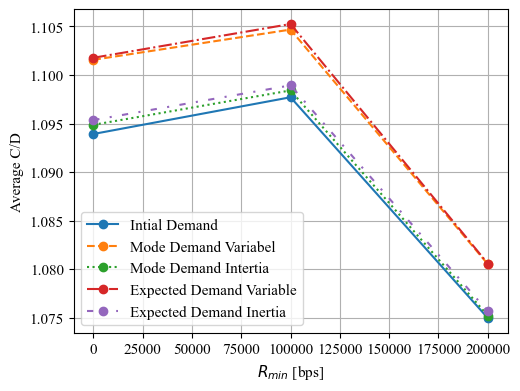

In [16]:
sticky_transitions = jnp.array([[1-0.7, 0.7],
                                         [0.3, 1-0.3]])

variable_transitions = jnp.array([[1-0.07, 0.07], 
                                 [0.03, 1-0.03 ]])

linestyles = ["-", "--", ":", "-.", (0, (3, 5, 1, 5))] 

fig = plt.figure(figsize=(5.6, 4.2))

rmins = df["rmin"].unique()

init = []

labels_for_plotting = ["Intial Demand","Mode Demand Variabel", "Mode Demand Intertia", "Expected Demand Variable", "Expected Demand Inertia"]

# Lets first plot without demand, transitions
for idx, label1 in enumerate(labels): 
    print("Processing label : ", label1)


    # Extract the for only the default version, that uses intial demands as the prediction
    df_in_label = df[df["label"] == label1]

    average_for_rmin = []


    for rmin in df_in_label["rmin"].unique(): 
        # Average the avg_CD across iterations
        averageCD  =  df_in_label[(df_in_label["rmin"] == rmin) & (df_in_label["O"] == 2)]["avg_CD"].to_numpy()
        #print(averageCD)
        average_for_rmin.append(np.mean(averageCD))

    init.append(average_for_rmin)
    print(idx)
    plt.plot(rmins, average_for_rmin, marker='o', label=labels_for_plotting[idx], linestyle=linestyles[idx])

plt.legend()
plt.xlabel("$R_{min}$ [bps]")
plt.ylabel("Average C/D") 
plt.savefig("avg_CD_sweep_results.pdf")
print(init)

### Calculate disconnect time

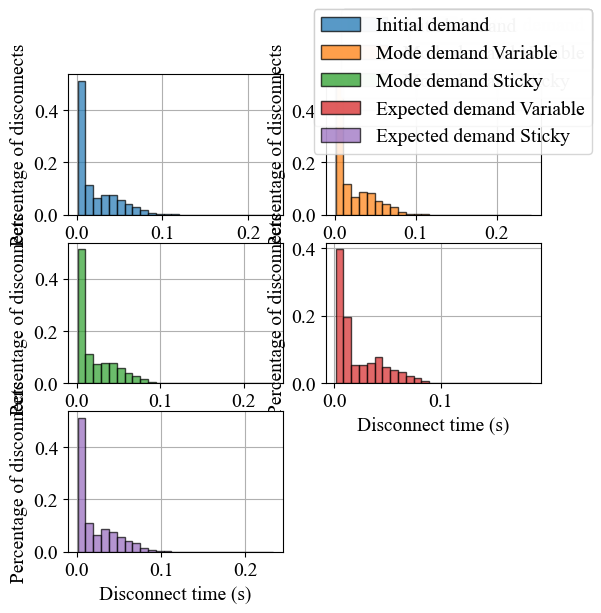

In [69]:
fig, axs = plt.subplots(3,2, figsize=(6.1, 6.2))
axs = axs.flatten()

fig.delaxes(axs[5])

color = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

for  idx, label in  enumerate(labels): 

    ax = axs[idx]

    disconnects = []

    for disc in df[(df["label"] == label) & (df["rmin"] == 100000)]["disconnect_times"]:
        disconnects.append(disc[disc != 0])
    
    disconnects = jnp.concatenate(disconnects) 
    weights_percent = np.ones(len(disconnects)) / len(disconnects)
    ax.set_xlabel("Disconnect time (s)")
    ax.set_ylabel("Percentage of disconnects")
    ax.hist(disconnects,bins=25, density=False,weights=weights_percent, label = label,zorder=3, edgecolor='black', color=color[idx], alpha=0.7)



    fig.legend()

Bbox(x0=0.125, y0=0.10999999999999999, x1=0.47727272727272724, y1=0.3364705882352941)
0.35227272727272724


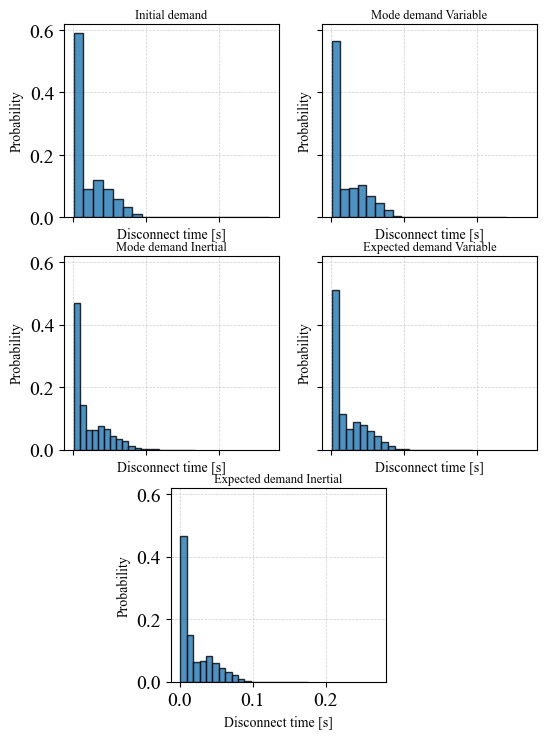

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp  

width_mm = 155
width_in = width_mm / 25.4

height_in = width_in * 1.4

labels_for_plot = [
    "Initial demand",
    "Mode demand Variable",
    "Mode demand Inertial",
    "Expected demand Variable",
    "Expected demand Inertial"
]


fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(width_in, height_in),
    sharex=True,
    sharey=True
)
axs = axs.flatten()

for idx, label in enumerate(labels):
    ax = axs[idx]
    
    # Collect all nonzero disconnect times for this label & rmin == 0:
    disconnects_list = []
    mask = (df["label"] == label) & (df["rmin"] == 0)
    for arr_times in df.loc[mask, "disconnect_times"]:
        nonzero = arr_times[arr_times != 0]
        if nonzero.size:
            disconnects_list.append(nonzero)
    
    if len(disconnects_list) == 0:
        # No data to plot—just give the title and continue
        ax.set_title(labels_for_plot[idx], fontsize=8, pad=4)
        continue
    
    # Concatenate and convert to a NumPy array for matplotlib
    disconnects = jnp.concatenate(disconnects_list)
    disconnects = np.array(disconnects)  # ensure it’s a NumPy array
    
    # Weights so histogram sums to 1
    weights = np.ones_like(disconnects) / len(disconnects)
    
    # Plot histogram
    n_bins = 20  # fewer bins can help when shrinking the figure
    ax.hist(
        disconnects,
        bins=n_bins,
        weights=weights,
        edgecolor="black",
        alpha=0.8,
        zorder=3
    )
    
    # Title, labels, grid
    ax.set_title(labels_for_plot[idx], fontsize=9, pad=4)
    ax.set_xlabel("Disconnect time [s]", fontsize=10)
    ax.set_ylabel("Probability", fontsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6, zorder=0)

fig.delaxes(axs[5])


ax_bottom = axs[4]

# Get the original position of the bottom‐left axes:
pos = ax_bottom.get_position()  # Bbox(x0, y0, width, height)
print(pos)
# We want to stretch it to occupy roughly the same y₀ and height,
# but go from x0≈0.06 to x1≈0.94 (i.e. span both columns).
# The exact numbers will depend on your original figure’s spacing.
#
# For example:
new_x0 = 0.3
width = pos.x1-pos.x0
print(width)
new_x1=  new_x0 + width

ax_bottom.set_position([new_x0, pos.y0, width, pos.height])


plt.savefig("disconnect_times_sweep_results.pdf", bbox_inches='tight', dpi=300)
plt.show()

### Implement the markov change model

In [22]:
df.keys()

Index(['reconfig_period', 'time_step', 'rmin', 'O',
       'user_state_transition_probability', 'label', 'demand', 'pred demand',
       'rates', 'schedule', 'achieved_capactiy', 'min_capacity',
       'avg_capacity', 'min_CD', 'avg_CD', 'Average_unmet_demand',
       'maximum_unmet_demand', 'disconnect_times', 'total_users',
       'total number_of_users_in_cell', 'iteration'],
      dtype='object')

In [24]:
O = df["O"].loc[0]

low_user_total= 80
high_user_total = 400


key = jrandom.PRNGKey(5)


time_window_small = jnp.zeros([80, O])
time_window_large = jnp.zeros([400, O])


key = jrandom.PRNGKey(0)
key_small = jrandom.split(key, (80,))
key_large = jrandom.split(key, (400, ) )

for idx, label in enumerate(labels):
    im_df =  df[(df["label"] == label) & (df["rmin"] == 0)]
    print(im_df.loc[0])
    A = jnp.array([[1-0.07, 0.07], # Transition probability matrix with a 10th of the probabiltiy for transition.
                   [0.03, 1-0.03]])

    step_size_of_O = df["reconfig_period"].loc[0]/O

    # Loop over the iterations
    for index, row in im_df.iterrows():
        
        # Loop over the cells

        for idx, demand in enumerate(row["demand"]):
            total_users_in_cell = int(row["total number_of_users_in_cell"][idx])
            if total_users_in_cell == 80:

                active_users = int(row["demand"][idx]/100000)
                print("Active users :", active_users)
                print("pred demand :", row["pred demand"][idx])

                # States
                states = jnp.concatenate([jnp.ones(active_users, dtype=jnp.int32), 
                                          jnp.zeros(low_user_total-active_users, dtype=jnp.int32)])

                # Window
                window = pl.users_state_change(A, 
                                               states, 
                                               time_window_small, 
                                               key_small)

                print("Window shape :", window.shape)

                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                print("Demand over time average :", demand_average_over_time)

                # Keys
                key_small = jrandom.split(key_small[0], 
                                          (50,))
                break
            else: 
                active_users = int(row["demand"][idx]/100000)
                # States
                states = jnp.concatenate([jnp.ones(active_users, dtype=jnp.int32), jnp.zeros(high_user_total-active_users, dtype=jnp.int32)])

                # Transition the user
                window = pl.users_state_change(A, states, time_window_large, key_large)

                # Demands 
                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0)*100000)

                # Keys
                key_large= jrandom.split(key_large[0], (400,))
            
        break
    break

reconfig_period                                                                      1
time_step                                                                        0.001
rmin                                                                                 0
O                                                                                    2
user_state_transition_probability    [[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...
label                                                                   Initial demand
demand                               [25100000.0, 4700000.0, 4700000.0, 4800000.0, ...
pred demand                          [25100000.0, 4700000.0, 4700000.0, 4800000.0, ...
rates                                [205073150.0, 205730100.0, 206062400.0, 206062...
schedule                             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
achieved_capactiy                    [26454436.0, 4937522.5, 4945497.5, 5151560.0, ...
min_capacity                               

In [6]:
Number_of_beams = 19 

number_of_cells = df["rates"].loc[0].shape[0]


fraction_of_time_beam_is_activated = Number_of_beams/(number_of_cells*df["reconfig_period"].loc[0])

even_rates_per_cell = []

for rates in df["rates"].loc[0]:
    even_rates_per_cell.append(fraction_of_time_beam_is_activated*rates)

even_rates_per_cell = jnp.array(even_rates_per_cell)


iterations = 15

# Loop over the different labels and O's
#for o in df["O"].unique():
#    for label in df["label"].unique():
#        for even_rate in even_rates_per_cell:
#            for i in range(iterations):
print(even_rates_per_cell)


[ 8697299.  8725160.  8739253.  8739253.  8725160.  8697299.  8683874.
  8753838.  8811837.  8856595.  8887062.  8902495.  8902495.  8887062.
  8856595.  8811837.  8753838.  8683874.  8739834.  8826893.  8902802.
  8965915.  9014743.  9048047.  9064931.  9064931.  9048047.  9014743.
  8965915.  8902802.  8826893.  8739834.  8768487.  8872193.  8966107.
  9048277.  9116819.  9169993.  9206329.  9224772.  9224772.  9206329.
  9169993.  9116819.  9048277.  8966107.  8872193.  8768487.  8768487.
  8887555.  8998611.  9099567.  9188237.  9262441.  9320162.  9359701.
  9379791.  9379791.  9359701.  9320162.  9262441.  9188237.  9099567.
  8998611.  8887555.  8768487.  8739834.  8872193.  8998611.  9116993.
  9225036.  9320271.  9400253.  9462642.  9505464.  9527256.  9527256.
  9505464.  9462642.  9400253.  9320271.  9225036.  9116993.  8998611.
  8872193.  8739834.  8683874.  8826893.  8966107.  9099567.  9225029.
  9339973.  9441662.  9527346.  9594365.  9640476.  9663971.  9663971.
  9640

## Generate results for a single cell, as an illustration and test
Generate a histogram and CDF

Labels  :  Mode demand Variable
Index(['reconfig_period', 'time_step', 'rmin', 'O',
       'user_state_transition_probability', 'label', 'demand', 'pred demand',
       'rates', 'schedule', 'achieved_capactiy', 'min_capacity',
       'avg_capacity', 'min_CD', 'avg_CD', 'Average_unmet_demand',
       'maximum_unmet_demand', 'disconnect_times', 'total_users',
       'total number_of_users_in_cell', 'iteration'],
      dtype='object')
Total users in cell :  400
Active users : 251
pred demand : 25520504.0
Achieved capacity : 26249364.0
Average CD :  0.98887616
Average demand over time :  26552438.0


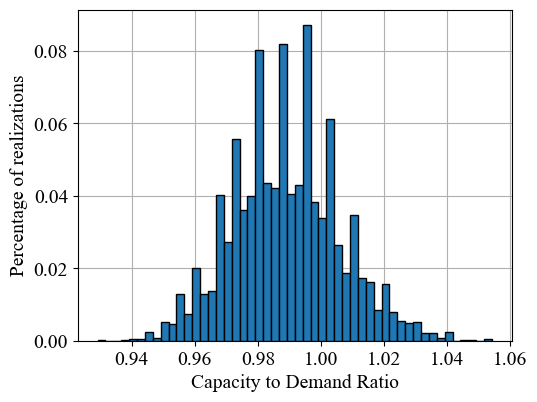

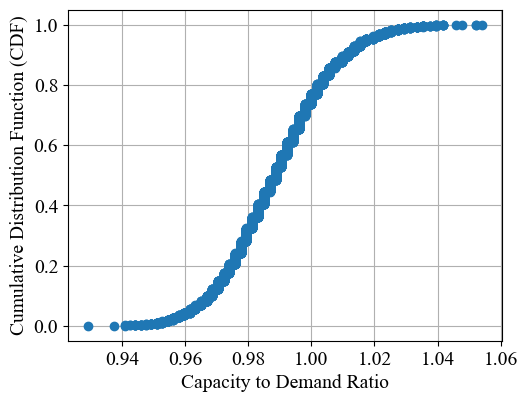

In [14]:
O = 2
number_of_realizations = 5000 

low_user_total= 80
high_user_total = 400


key = jrandom.PRNGKey(5)


time_window_small = jnp.zeros([low_user_total, O])
time_window_large = jnp.zeros([high_user_total, O])


key = jrandom.PRNGKey(5)
key_small = jrandom.split(key, (80,))
key_large = jrandom.split(key, (400, ) )

print("Labels  : ", labels[1])


single_optimisation =  df[(df["label"] == labels[4]) & (df["rmin"] == 0) & (df["O"] == 2) & (df["iteration"] == 0)]

print(single_optimisation.keys())

A = jnp.array([[1-0.7, 0.7], # Transition probability matrix with a 10th of the probabiltiy for transition.
                [0.3, 1-0.3]])

# Run for one large cell
total_users_in_cell = single_optimisation["total number_of_users_in_cell"].to_list()[0][0]
print("Total users in cell : ", total_users_in_cell)
active_users = int(single_optimisation["demand"].to_list()[0][0]/100000)

print("Active users :", active_users)
print("pred demand :", single_optimisation["pred demand"].to_list()[0][0])

# Capacity in that cell
achieved_capacity = single_optimisation["achieved_capactiy"].to_list()[0][0]

print("Achieved capacity :", achieved_capacity)
CD = []

demand_average_over_time_list = []

for n in range(number_of_realizations):
    # States
    states = jnp.concatenate([jnp.ones(active_users, dtype=jnp.int32), 
                                jnp.zeros(total_users_in_cell-active_users, dtype=jnp.int32)])

    # Window
    window = pl.users_state_change(A, 
                                    states, 
                                    time_window_large, 
                                    key_large)


    demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

    demand_average_over_time_list.append(demand_average_over_time)

    CD.append(achieved_capacity/demand_average_over_time)

    key_large = jrandom.split(key_large[0], (high_user_total,))

CD = jnp.array(CD)
print("Average CD : ", jnp.mean(CD))

demand_average_over_time_list = jnp.array(demand_average_over_time_list)
print("Average demand over time : ", jnp.mean(demand_average_over_time_list))

plt.figure(figsize = (5.6, 4.3))
weights_percent = np.ones(len(CD)) / len(CD)
plt.hist(CD, bins=50, density=False, weights = weights_percent, edgecolor='black', alpha=1,zorder=3)
plt.xlabel("Capacity to Demand Ratio")
plt.ylabel("Percentage of realizations")
plt.savefig("CD_histogram_single_cell.pdf")


sorted_CD = np.sort(CD)
n = len(sorted_CD)
cdf = np.arange(1, n + 1) / n

plt.figure(figsize=(5.6, 4.3))
plt.plot(sorted_CD, cdf, marker='o', linestyle='none')
plt.xlabel("Capacity to Demand Ratio")
plt.ylabel("Cumulative Distribution Function (CDF)")
plt.savefig("CD_cdf_single_cell.pdf")

### Loop over all cells and iterations for each different configurations
Different labels and rmin

In [ ]:
config.keys()

dict_keys(['reconfig_period', 'time_step', 'rmin', 'user_turn_on_probability', 'user_turn_off_probability', 'user_state_transition_probability', 'O', 'iterations', 'high_density_user_amount', 'low_density_user_amount'])

In [ ]:
df.keys()

Index(['reconfig_period', 'time_step', 'rmin', 'O',
       'user_state_transition_probability', 'label', 'demand', 'pred demand',
       'rates', 'schedule', 'achieved_capactiy', 'min_capacity',
       'avg_capacity', 'min_CD', 'avg_CD', 'Average_unmet_demand',
       'maximum_unmet_demand', 'disconnect_times', 'total_users',
       'total number_of_users_in_cell', 'iteration'],
      dtype='object')

In [37]:
df["label"].unique()

array(['Initial demand', 'Mode demand Variable', 'Mode demand Sticky',
       'Expected demand Variable', 'Expected demand Sticky'], dtype=object)

In [70]:
df["label"]

0                Initial demand
1          Mode demand Variable
2            Mode demand Sticky
3      Expected demand Variable
4        Expected demand Sticky
                 ...           
445              Initial demand
446        Mode demand Variable
447          Mode demand Sticky
448    Expected demand Variable
449      Expected demand Sticky
Name: label, Length: 450, dtype: object

In [11]:
## Find the nadir cell and the edge cell instead of the all cells.
# And then simply produce the mask for all the cell that is the closest and the furthest from the nadir cell.

nadir_cell , edge_cell = jnp.argmax(df["rates"].loc[0]), jnp.argmin(df["rates"].loc[0])

nadir_cell, edge_cell

(Array(211, dtype=int32), Array(6, dtype=int32))

In [101]:
df.loc[0:5]

,reconfig_period,time_step,rmin,O,user_state_transition_probability,label,demand,pred demand,rates,schedule,...,min_capacity,avg_capacity,min_CD,avg_CD,Average_unmet_demand,maximum_unmet_demand,disconnect_times,total_users,total number_of_users_in_cell,iteration
0,1,0.001,0,2,"[[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...",Initial demand,"[25100000.0, 4700000.0, 4700000.0, 4800000.0, ...","[25100000.0, 4700000.0, 4700000.0, 4800000.0, ...","[205073150.0, 205730100.0, 206062400.0, 206062...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,3352761.5,9280208.0,1.0493842,1.069556,0.0,0.0,"[[0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",39126.0,"[400, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, ...",0
1,1,0.001,0,2,"[[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...",Mode demand Variable,"[25100000.0, 4700000.0, 4700000.0, 4800000.0, ...","[28000000.0, 5600000.0, 5600000.0, 5600000.0, ...","[205073150.0, 205730100.0, 206062400.0, 206062...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,5063499.0,9279803.0,0.8482951,1.0764582,58870.445,2720812.0,"[[0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",39126.0,"[400, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, ...",0
2,1,0.001,0,2,"[[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...",Mode demand Sticky,"[25100000.0, 4700000.0, 4700000.0, 4800000.0, ...","[25500000.0, 4850000.0, 4850000.0, 4900000.0, ...","[205073150.0, 205730100.0, 206062400.0, 206062...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,3562309.0,9280735.0,1.026967,1.0697203,0.0,0.0,"[[0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",39126.0,"[400, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, ...",0
3,1,0.001,0,2,"[[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...",Expected demand Variable,"[25100000.0, 4700000.0, 4700000.0, 4800000.0, ...","[28000000.0, 5600000.0, 5600000.0, 5600000.5, ...","[205073150.0, 205730100.0, 206062400.0, 206062...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,5054471.0,9277848.0,0.8482951,1.076333,59178.418,2498186.0,"[[0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",39126.0,"[400, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, ...",0
4,1,0.001,0,2,"[[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...",Expected demand Sticky,"[25100000.0, 4700000.0, 4700000.0, 4800000.0, ...","[25520504.0, 4830500.0, 4830500.0, 4915999.5, ...","[205073150.0, 205730100.0, 206062400.0, 206062...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,3562309.0,9280424.0,1.0261428,1.0708817,0.0,0.0,"[[0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",39126.0,"[400, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, ...",0
5,1,0.001,0,2,"[[[[0.3 0.7], [0.3 0.7]], [[0.3 0.7], [0.3 0.7...",Initial demand,"[4600000.0, 5000000.0, 5600000.0, 4900000.0, 4...","[4600000.0, 5000000.0, 5600000.0, 4900000.0, 4...","[205073150.0, 205730100.0, 206062400.0, 206062...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,4114601.8,9286218.0,1.1379569,1.1572751,0.0,0.0,"[[0.0, 0.0, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",36141.0,"[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 4...",1


In [102]:
number_of_realizations = 100

O = config["O"]

rmins = config["rmin"]

iterations = config["iterations"]

number_of_cells = df.loc[0]["schedule"].T.shape[0]

CD_over_loops = []

CD_O_equal_two_edge = []
CD_O_equal_two_nadir = []

CD_O_equal_five_edge = []
CD_O_equal_five_nadir= []

first_two_loops = True
first_five_loops = True 

cells_of_interst = [nadir_cell, edge_cell]

# Loop through labels
for idx, label in enumerate(labels):
    if idx == 1 or idx == 3:
        A = df["user_state_transition_probability"].loc[0][0][0]
        print("A Variable:", A)
    else:
        A = df["user_state_transition_probability"].loc[0][1][0]
        print("A Sticky:",A)
    # Loop over number of steps
    
    for o in O:
        time_window_small = jnp.zeros([low_user_total, o])
        time_window_large = jnp.zeros([high_user_total, o])
        # Loop over rmins
        for rmin in rmins:
            CD_nadir = []
            CD_edge = []
            # Loop over iterations 
            for iter in range(iterations):
                print("Processing label : ", label, " O : ", o, " rmin : ", rmin, " iter : ", iter)
                im_df = df[(df["label"] == label) & (df["O"] == o) & (df["rmin"] == rmin) & (df["iteration"] == iter)]

                capacity_list_for_all_cells = im_df["achieved_capactiy"].to_numpy()[0]

                total_users_in_cell_list = im_df["total number_of_users_in_cell"].to_list()


                active_users = im_df["demand"].to_numpy()[0]/100000

                for idk, cell_numbering in enumerate(cells_of_interst):
                    if idk == 0:
                        # Loop over iterations
                        for n in range(number_of_realizations):

                            if total_users_in_cell_list[0][cell_numbering] == low_user_total:

                                states = jnp.concatenate([jnp.ones(int(active_users[cell_numbering]), dtype=jnp.int32), 
                                                            jnp.zeros(total_users_in_cell_list[0][cell_numbering]-int(active_users[cell_numbering]), dtype=jnp.int32)])

                                # Window
                                window = pl.users_state_change(A, 
                                                                states, 
                                                                time_window_small, 
                                                                key_small)


                                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                                CD_nadir.append(capacity_list_for_all_cells[cell_numbering]/demand_average_over_time)

                                if o == 2 and first_two_loops:
                                    CD_O_equal_two_nadir.append(even_rates_per_cell[cell_numbering]/demand_average_over_time)
                                elif o == 5 and first_five_loops:
                                    CD_O_equal_five_nadir.append(even_rates_per_cell[cell_numbering]/demand_average_over_time)

                                key_small = jrandom.split(key_small[0], (low_user_total,))
                            else:

                                states = jnp.concatenate([jnp.ones(int(active_users[cell_numbering]), dtype=jnp.int32), 
                                                            jnp.zeros(total_users_in_cell_list[0][cell_numbering]-int(active_users[cell_numbering]), dtype=jnp.int32)])

                                # Window
                                window = pl.users_state_change(A, 
                                                                states, 
                                                                time_window_large, 
                                                                key_large)


                                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                                CD_nadir.append(capacity_list_for_all_cells[cell_numbering]/demand_average_over_time)

                                if o == 2 and first_two_loops:
                                    CD_O_equal_two_nadir.append(even_rates_per_cell[cell_numbering]/demand_average_over_time)
                                elif o == 5 and first_five_loops:
                                    CD_O_equal_five_nadir.append(even_rates_per_cell[cell_numbering]/demand_average_over_time)

                                key_large = jrandom.split(key_large[0], (high_user_total,))
                    else:
                        # Loop over iterations
                        for n in range(number_of_realizations):

                            if total_users_in_cell_list[0][cell_numbering] == low_user_total:

                                states = jnp.concatenate([jnp.ones(int(active_users[cell_numbering]), dtype=jnp.int32), 
                                                            jnp.zeros(total_users_in_cell_list[0][cell_numbering]-int(active_users[cell_numbering]), dtype=jnp.int32)])

                                # Window
                                window = pl.users_state_change(A, 
                                                                states, 
                                                                time_window_small, 
                                                                key_small)


                                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                                CD_edge.append(capacity_list_for_all_cells[cell_numbering]/demand_average_over_time)
                                
                                if o == 2 and first_two_loops:
                                    CD_O_equal_two_edge.append(even_rates_per_cell[cell_numbering]/demand_average_over_time)
                                elif o == 5 and first_five_loops:
                                    CD_O_equal_five_edge.append(even_rates_per_cell[cell_numbering]/demand_average_over_time)

                                key_small = jrandom.split(key_small[0], (low_user_total,))
                            else:

                                states = jnp.concatenate([jnp.ones(int(active_users[cell_numbering]), dtype=jnp.int32), 
                                                            jnp.zeros(total_users_in_cell_list[0][cell_numbering]-int(active_users[cell_numbering]), dtype=jnp.int32)])

                                # Window
                                window = pl.users_state_change(A, 
                                                                states, 
                                                                time_window_large, 
                                                                key_large)


                                demand_average_over_time = jnp.mean(jnp.sum(window, axis= 0))*100000

                                CD_edge.append(capacity_list_for_all_cells[cell_numbering]/demand_average_over_time)

                                if o == 2 and first_two_loops:
                                    CD_O_equal_two_edge.append(even_rates_per_cell[cell_numbering]/demand_average_over_time)
                                elif o == 5 and first_five_loops:
                                    CD_O_equal_five_edge.append(even_rates_per_cell[cell_numbering]/demand_average_over_time)

                                key_large = jrandom.split(key_large[0], (high_user_total,))
    
            print("Append CD_over_loops")
            CD_over_loops.append({"CD_nadir" : CD_nadir,
                                  "CD_edge"   :CD_edge,
                                  "Label"    : label,
                                  "rmin"     : rmin,
                                  "O"        : o})
        if o == 2 :
            first_two_loops = False
            print("The statement is false for o = 2")

        if o == 5:
            first_five_loops = False
            print("The statement is false for o  =  5")


A Sticky: [[0.93 0.07]
 [0.03 0.97]]
Processing label :  Initial demand  O :  2  rmin :  0  iter :  0
Processing label :  Initial demand  O :  2  rmin :  0  iter :  1
Processing label :  Initial demand  O :  2  rmin :  0  iter :  2
Processing label :  Initial demand  O :  2  rmin :  0  iter :  3
Processing label :  Initial demand  O :  2  rmin :  0  iter :  4
Processing label :  Initial demand  O :  2  rmin :  0  iter :  5
Processing label :  Initial demand  O :  2  rmin :  0  iter :  6
Processing label :  Initial demand  O :  2  rmin :  0  iter :  7
Processing label :  Initial demand  O :  2  rmin :  0  iter :  8
Processing label :  Initial demand  O :  2  rmin :  0  iter :  9
Processing label :  Initial demand  O :  2  rmin :  0  iter :  10
Processing label :  Initial demand  O :  2  rmin :  0  iter :  11
Processing label :  Initial demand  O :  2  rmin :  0  iter :  12
Processing label :  Initial demand  O :  2  rmin :  0  iter :  13
Processing label :  Initial demand  O :  2  rmin 

KeyboardInterrupt: 

(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    2.,  263.,  824.,  844.,
         513.,  395.,  392.,  166.,   50.,   45.,    6.]),
 array([0.38174585, 0.47522199, 0.56869811, 0.66217428, 0.7556504 ,
        0.84912658, 0.94260269, 1.03607881, 1.12955499, 1.22303116,
        1.31650722, 1.4099834 , 1.50345957, 1.59693563, 1.69041181,
        1.78388798, 1.87736416, 1.97084022, 2.06431651, 2.15779257,
        2.25126863, 2.34474492, 2.43822098, 2.53169703, 2.62517333,
        2.71864939]),
 <BarContainer object of 25 artists>)

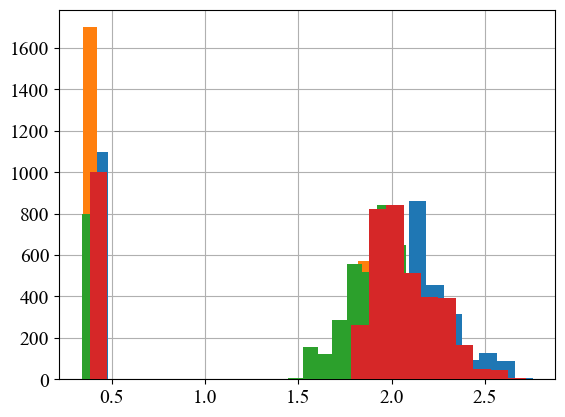

In [51]:
CD_over_loops_df = pd.DataFrame(CD_over_loops)



plt.hist(CD_O_equal_five_nadir,bins=25,zorder=3)
plt.hist(CD_O_equal_five_edge,bins=25,zorder=3)
plt.hist(CD_O_equal_two_edge,bins=25,zorder=3)
plt.hist(CD_O_equal_two_nadir,bins=25,zorder=3)

In [58]:
CD_over_loops_df.keys()

Index(['CD_nadir', 'CD_ege', 'Label', 'rmin', 'O'], dtype='object')

(6,)
0
1
2
3
4


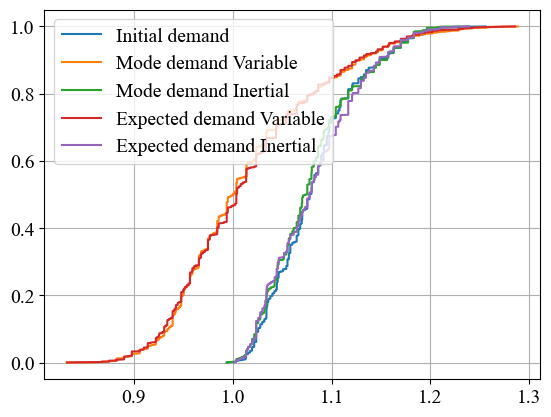

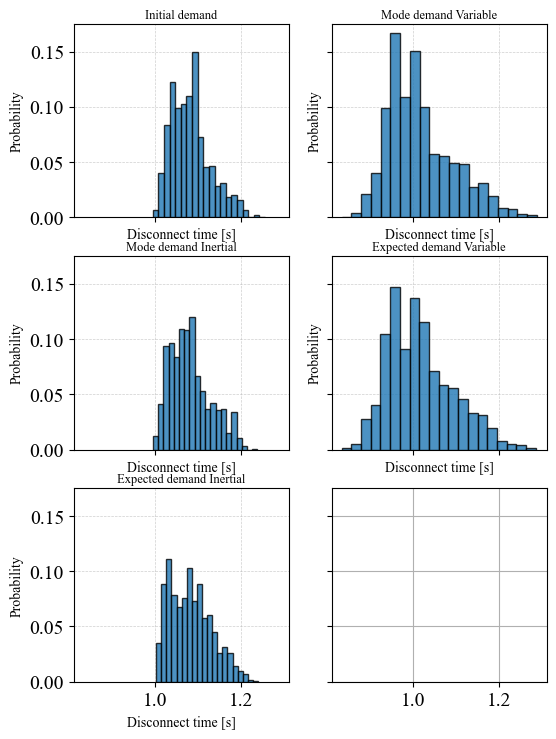

<Figure size 560x420 with 0 Axes>

<Figure size 560x420 with 0 Axes>

<Figure size 560x420 with 0 Axes>

<Figure size 560x420 with 0 Axes>

<Figure size 560x420 with 0 Axes>

In [96]:
# Generate histogram for CD and CDF

CD_Rmin_zero = CD_over_loops_df[(CD_over_loops_df["rmin"] == 0) & (CD_over_loops_df["O"] == 2)]

width_mm = 155
width_in = width_mm / 25.4

height_in = width_in * 1.4

labels_for_plot = [
    "Initial demand",
    "Mode demand Variable",
    "Mode demand Inertial",
    "Expected demand Variable",
    "Expected demand Inertial"
]

fig2 , axs2 = plt.subplots(1,1)


fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(width_in, height_in),
    sharex=True,
    sharey=True
)
axs = axs.flatten()


i = 0
print(axs.shape)

for idx, row in CD_Rmin_zero.iterrows():

    plt.figure(figsize=(5.6, 4.2))
    

    CD = np.array(row["CD_ege"])  
    
    # Weights so histogram sums to 1
    weights = np.ones_like(CD) / len(CD)
    
    # Plot histogram
    n_bins = 20  # fewer bins can help when shrinking the figure
    axs[i].hist(
        CD,
        bins=n_bins,
        weights=weights,
        edgecolor="black",
        alpha=0.8,
        zorder=3
    )
    print(i)
    # Title, labels, grid
    axs[i].set_title(labels_for_plot[i], fontsize=9, pad=4)
    axs[i].set_xlabel("C/D", fontsize=10)
    axs[i].set_ylabel("Probability", fontsize=10)
    axs[i].grid(True, linestyle="--", linewidth=0.5, alpha=0.6, zorder=0)


    n = len(sorted_CD)
    sorted_CD = np.sort(CD)
    cdf = np.arange(1, n + 1) / n

    axs2.plot(sorted_CD, cdf, label=labels_for_plot[i])
    axs2.legend()

    i +=1